In [1]:
# Table of Contents

# 01. Introductions
# 02. KNN Classifier
# 03. Naive Bayes Classifier
# 04. Decision trees and Random Forests
# 05. Imbalance Solutions

In [2]:
# 01. Introductions

# Classification is a kind of supervised learning. It is used to predict the value in a nominal variable 
# which is also called 'label'. The factors that are used for predictions are called features.

import numpy as np
import scipy as sp
import pandas as pd
from IPython.display import display, HTML

df=pd.read_csv('/Users/narendravenkatesan/Downloads/Loans.csv')
cols=df.columns
# print out and display dataframe as tables in HTML
display(HTML(df.head(10).to_html()))

# replace missing values in numerical variables by using mean value #################################
df["Monthly Debt"].fillna(df["Monthly Debt"].mean(), inplace=True)
df["Annual Income"].fillna(df["Annual Income"].mean(), inplace=True)
df["Credit Score"].fillna(df["Credit Score"].mean(), inplace=True)
df["Years of Credit History"].fillna(df["Years of Credit History"].mean(), inplace=True)
df["Months since last delinquent"].fillna(df["Months since last delinquent"].mean(), inplace=True)
df["Maximum Open Credit"].fillna(df["Maximum Open Credit"].mean(), inplace=True)
df["Bankruptcies"].fillna(df["Bankruptcies"].mean(), inplace=True)
df["Tax Liens"].fillna(df["Tax Liens"].mean(), inplace=True)

,Loan Status,Current Loan Amount,Term,Credit Score,Annual Income,Years in current job,Home Ownership,Purpose,Monthly Debt,Years of Credit History,Months since last delinquent,Number of Open Accounts,Number of Credit Problems,Current Credit Balance,Maximum Open Credit,Bankruptcies,Tax Liens
0,Fully Paid,445412,Short Term,709.0,1167493.0,8 years,Home Mortgage,Home Improvements,5214.74,17.2,NaN,6,1,228190,416746.0,1.0,0.0
1,Fully Paid,262328,Short Term,NaN,NaN,10+ years,Home Mortgage,Debt Consolidation,33295.98,21.1,8.0,35,0,229976,850784.0,0.0,0.0
2,Fully Paid,99999999,Short Term,741.0,2231892.0,8 years,Own Home,Debt Consolidation,29200.53,14.9,29.0,18,1,297996,750090.0,0.0,0.0
3,Fully Paid,347666,Long Term,721.0,806949.0,3 years,Own Home,Debt Consolidation,8741.90,12.0,NaN,9,0,256329,386958.0,0.0,0.0
4,Fully Paid,176220,Short Term,NaN,NaN,5 years,Rent,Debt Consolidation,20639.70,6.1,NaN,15,0,253460,427174.0,0.0,0.0
5,Charged Off,206602,Short Term,7290.0,896857.0,10+ years,Home Mortgage,Debt Consolidation,16367.74,17.3,NaN,6,0,215308,272448.0,0.0,0.0
6,Fully Paid,217646,Short Term,730.0,1184194.0,< 1 year,Home Mortgage,Debt Consolidation,10855.08,19.6,10.0,13,1,122170,272052.0,1.0,0.0
7,Charged Off,648714,Long Term,NaN,NaN,< 1 year,Home Mortgage,Buy House,14806.13,8.2,8.0,15,0,193306,864204.0,0.0,0.0
8,Fully Paid,548746,Short Term,678.0,2559110.0,2 years,Rent,Debt Consolidation,18660.28,22.6,33.0,4,0,437171,555038.0,0.0,0.0
9,Fully Paid,215952,Short Term,739.0,1454735.0,< 1 year,Rent,Debt Consolidation,39277.75,13.9,NaN,20,0,669560,1021460.0,0.0,0.0


Column Datatypes:
 Loan Status                      object
Current Loan Amount               int64
Term                             object
Credit Score                    float64
Annual Income                   float64
Years in current job             object
Home Ownership                   object
Purpose                          object
Monthly Debt                    float64
Years of Credit History         float64
Months since last delinquent    float64
Number of Open Accounts           int64
Number of Credit Problems         int64
Current Credit Balance            int64
Maximum Open Credit             float64
Bankruptcies                    float64
Tax Liens                       float64
dtype: object


'Data Example:'

,Loan Status,Current Loan Amount,Credit Score,Annual Income,Years in current job,Home Ownership,Monthly Debt,Years of Credit History,Months since last delinquent,Number of Open Accounts,Number of Credit Problems,Current Credit Balance,Maximum Open Credit,Bankruptcies,Tax Liens,Purpose_Business Loan,Purpose_Buy House,Purpose_Buy a Car,Purpose_Debt Consolidation,Purpose_Educational Expenses,Purpose_Home Improvements,Purpose_Medical Bills,Purpose_Other,Purpose_Take a Trip,Purpose_major_purchase,Purpose_moving,Purpose_other,Purpose_renewable_energy,Purpose_small_business,Purpose_vacation,Purpose_wedding,Term_Long Term,Term_Short Term
0,Fully Paid,445412,709.000000,1.167493e+06,8 years,Home Mortgage,5214.74,17.2,34.901321,6,1,228190,416746.0,1.0,0.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
1,Fully Paid,262328,1076.456089,1.378277e+06,10+ years,Home Mortgage,33295.98,21.1,8.000000,35,0,229976,850784.0,0.0,0.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,Fully Paid,99999999,741.000000,2.231892e+06,8 years,Own Home,29200.53,14.9,29.000000,18,1,297996,750090.0,0.0,0.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,Fully Paid,347666,721.000000,8.069490e+05,3 years,Own Home,8741.90,12.0,34.901321,9,0,256329,386958.0,0.0,0.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,Fully Paid,176220,1076.456089,1.378277e+06,5 years,Rent,20639.70,6.1,34.901321,15,0,253460,427174.0,0.0,0.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
5,Charged Off,206602,7290.000000,8.968570e+05,10+ years,Home Mortgage,16367.74,17.3,34.901321,6,0,215308,272448.0,0.0,0.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
6,Fully Paid,217646,730.000000,1.184194e+06,< 1 year,Home Mortgage,10855.08,19.6,10.000000,13,1,122170,272052.0,1.0,0.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
7,Charged Off,648714,1076.456089,1.378277e+06,< 1 year,Home Mortgage,14806.13,8.2,8.000000,15,0,193306,864204.0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
8,Fully Paid,548746,678.000000,2.559110e+06,2 years,Rent,18660.28,22.6,33.000000,4,0,437171,555038.0,0.0,0.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
9,Fully Paid,215952,739.000000,1.454735e+06,< 1 year,Rent,39277.75,13.9,34.901321,20,0,669560,1021460.0,0.0,0.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1


Selected numerical columns:
 ['Current Loan Amount', 'Credit Score', 'Annual Income', 'Monthly Debt', 'Years of Credit History', 'Months since last delinquent', 'Number of Open Accounts', 'Number of Credit Problems', 'Current Credit Balance', 'Maximum Open Credit', 'Bankruptcies', 'Tax Liens']


,Loan Status,Current Loan Amount,Credit Score,Annual Income,Years in current job,Home Ownership,Monthly Debt,Years of Credit History,Months since last delinquent,Number of Open Accounts,Number of Credit Problems,Current Credit Balance,Maximum Open Credit,Bankruptcies,Tax Liens,Purpose_Business Loan,Purpose_Buy House,Purpose_Buy a Car,Purpose_Debt Consolidation,Purpose_Educational Expenses,Purpose_Home Improvements,Purpose_Medical Bills,Purpose_Other,Purpose_Take a Trip,Purpose_major_purchase,Purpose_moving,Purpose_other,Purpose_renewable_energy,Purpose_small_business,Purpose_vacation,Purpose_wedding,Term_Long Term,Term_Short Term
0,Fully Paid,0.004347,0.017906,0.006592,8 years,Home Mortgage,0.011965,0.203288,0.198303,0.078947,0.066667,0.006940,0.000271,0.142857,0.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
1,Fully Paid,0.002516,0.070968,0.007866,10+ years,Home Mortgage,0.076394,0.261584,0.045455,0.460526,0.000000,0.006995,0.000553,0.000000,0.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,Fully Paid,1.000000,0.022527,0.013024,8 years,Own Home,0.066998,0.168909,0.164773,0.236842,0.066667,0.009063,0.000487,0.000000,0.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,Fully Paid,0.003369,0.019639,0.004413,3 years,Own Home,0.020057,0.125561,0.198303,0.118421,0.000000,0.007796,0.000251,0.000000,0.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,Fully Paid,0.001654,0.070968,0.007866,5 years,Rent,0.047356,0.037369,0.198303,0.197368,0.000000,0.007709,0.000277,0.000000,0.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
5,Charged Off,0.001958,0.968231,0.004957,10+ years,Home Mortgage,0.037554,0.204783,0.198303,0.078947,0.000000,0.006549,0.000177,0.000000,0.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
6,Fully Paid,0.002069,0.020939,0.006693,< 1 year,Home Mortgage,0.024906,0.239163,0.056818,0.171053,0.066667,0.003716,0.000177,0.142857,0.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
7,Charged Off,0.006380,0.070968,0.007866,< 1 year,Home Mortgage,0.033971,0.068759,0.045455,0.197368,0.000000,0.005879,0.000561,0.000000,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
8,Fully Paid,0.005380,0.013430,0.015002,2 years,Rent,0.042814,0.284006,0.187500,0.052632,0.000000,0.013296,0.000360,0.000000,0.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
9,Fully Paid,0.002052,0.022238,0.008328,< 1 year,Rent,0.090119,0.153961,0.198303,0.263158,0.000000,0.020364,0.000663,0.000000,0.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1


/var/folders/m0/f9ydkpw52fl7g1pqg646kctm0000gn/T/ipykernel_85914/1646656852.py:51: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  x = df_knn.drop('Purpose',1)


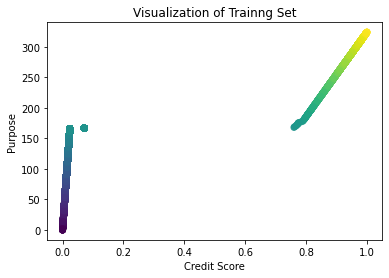

ValueError: could not convert string to float: 'Fully Paid'

In [3]:
# 02. KNN Classifier ################################################################################
# Requirements: 1). numerical features; 2). normalized features
# Parameters: distance measure and value of K


# Data preprocessing ################################################################################
print('Column Datatypes:\n',df.dtypes)
# convert all nominal variables to binary variables
df_raw=df.copy(deep=True) 
df_knn=df.copy(deep=True) 
# create new binary columns
df_dummies=pd.get_dummies(df_knn[['Purpose','Term']])
# add them to dataframe
df_knn=df_knn.join(df_dummies)
# drop original columns
df_knn=df_knn.drop('Purpose',axis=1)
df_knn=df_knn.drop('Term', axis=1)

display('Data Example:',HTML(df_knn.head(10).to_html()))

# Normalized all numerical features
# find numeric columns
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
cols_numeric = df_knn.select_dtypes(include=numerics).columns.tolist()
print('Selected numerical columns:\n',cols_numeric)    

# min-max normalization to scale [0, 1]
for col in cols_numeric:
    df_knn[col]=(df_knn[col]-df_knn[col].min())/(df_knn[col].max()-df_knn[col].min())

display(HTML(df_knn.head(10).to_html()))

# Build KNN models and evaluate the models ############################################################

# By hold-out evaluations ###############################################
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import matplotlib as mpl
import seaborn as sns

# preprocess label, since KNN requires label encoding
from sklearn import preprocessing


y = df_knn['Credit Score'] # define label as nominal values
le = preprocessing.LabelEncoder()
le.fit(y)
y_encoded = le.transform(y) # encode nominal labels to integers #####################################

df_knn['Purpose'] = y_encoded
x = df_knn.drop('Purpose',1)
y = df_knn['Credit Score'] 

x_train, x_test, y_train, y_test = train_test_split(df_knn, y_encoded, test_size=0.2)
# print(type(y_train), 'count of unique values = ', y_train.unique().size)

# Visualize train set
plt.figure(1)
plt.scatter(x_train['Credit Score'], x_train['Purpose'], c=y_train, alpha = 0.8)
plt.xlabel('Credit Score')
plt.ylabel('Purpose')
plt.title('Visualization of Trainng Set')
plt.show()
plt.close()

# build and eval models
from sklearn import neighbors
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

# API for KNeighborsClassifier


for k in range(1, 20, 2): 
    clf=neighbors.KNeighborsClassifier(k, weights='uniform')
    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    print('K =', k, ', Accuracy: ', accuracy_score(y_test, y_pred), ', Precision: ', precision_score(y_test, y_pred, average='micro'),
         ', Recall: ', recall_score(y_test, y_pred, average='micro'))
    
# Visualize the best model on the test set
clf=neighbors.KNeighborsClassifier(1, weights='uniform')
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)

plt.figure(2)
plt.scatter(x_test['Credit Score'], x_test['Purpose'], c=y_pred, alpha = 0.7)
plt.xlabel('Credit Score')
plt.ylabel('Purpose')
plt.title('Visualization of Testing Set')
plt.show()
plt.close()


# By N-fold cross evaluations ###############################################
from sklearn.model_selection import cross_val_score

for k in range(1, 10, 2): 
    clf=neighbors.KNeighborsClassifier(k, weights='uniform')
    acc=cross_val_score(clf, x, y, cv=5, scoring='accuracy').mean()
    print('K =', k, ', Accuracy: ',acc)

In [4]:
# 03. Naive Bayes Classifier ################################################################################
# Requirements: 1). nominal features; 2). assumption of conditionally indepenence
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.model_selection import cross_val_score
# Pre-processing ###############################################
print('Column data types:\n',df_raw.dtypes)
df_nb=df_raw.copy(deep=True)

# convert numerical to categorical data, e.g., MOnthly Debt #################################
df_nb['Monthly Debt'] = pd.cut(df_nb['Monthly Debt'],2)
df_nb['Annual Income'] = pd.cut(df_nb['Annual Income'],3)
df_nb["Maximum Open Credit"] = pd.cut(df_nb["Maximum Open Credit"],3)
df_nb["Bankruptcies"] = pd.cut(df_nb["Bankruptcies"],3)
df_nb["Tax Liens"] = pd.cut(df_nb["Tax Liens"],3)

display('Data Example',HTML(df_nb.head(5).to_html()))

# by hold-out evaluation ###########################################################
y=df_nb['Purpose']
le = preprocessing.LabelEncoder()
le.fit(y)
y_encoded = le.transform(y) # encode nominal labels to integers #####################################


# transform categorical data to numerical data, i.e., one-hot encoding
print(df_nb.dtypes)
df_nb=pd.get_dummies(df_nb.drop('Purpose',axis=1))
df_nb['Purpose']=y_encoded
display(HTML(df_nb.head(5).to_html()))

# API for GaussianNB
# https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html#sklearn.naive_bayes.GaussianNB

x_train, x_test, y_train, y_test = train_test_split(df_nb, y_encoded, test_size=0.2)

clf = GaussianNB()
clf.fit(x_train, y_train)
y_pred=clf.predict(x_test)
print("Accuracy by Hold-out Eval:",accuracy_score(y_pred,y_test))

# by N-fold evaluation ###########################################################
y=df_nb['Purpose']
x=df_nb.drop('Purpose',axis=1)
clf = GaussianNB()
acc=cross_val_score(clf, x, y, cv=5, scoring='accuracy').mean()
print("Accuracy by N-fold Cross Validation:",acc)



Column data types:
 Loan Status                      object
Current Loan Amount               int64
Term                             object
Credit Score                    float64
Annual Income                   float64
Years in current job             object
Home Ownership                   object
Purpose                          object
Monthly Debt                    float64
Years of Credit History         float64
Months since last delinquent    float64
Number of Open Accounts           int64
Number of Credit Problems         int64
Current Credit Balance            int64
Maximum Open Credit             float64
Bankruptcies                    float64
Tax Liens                       float64
dtype: object


'Data Example'

,Loan Status,Current Loan Amount,Term,Credit Score,Annual Income,Years in current job,Home Ownership,Purpose,Monthly Debt,Years of Credit History,Months since last delinquent,Number of Open Accounts,Number of Credit Problems,Current Credit Balance,Maximum Open Credit,Bankruptcies,Tax Liens
0,Fully Paid,445412,Short Term,709.000000,"(-88853.766, 55236882.333]",8 years,Home Mortgage,Home Improvements,"(-435.843, 217921.64]",17.2,34.901321,6,1,228190,"(-1539737.892, 513245964.0]","(-0.007, 2.333]","(-0.015, 5.0]"
1,Fully Paid,262328,Short Term,1076.456089,"(-88853.766, 55236882.333]",10+ years,Home Mortgage,Debt Consolidation,"(-435.843, 217921.64]",21.1,8.000000,35,0,229976,"(-1539737.892, 513245964.0]","(-0.007, 2.333]","(-0.015, 5.0]"
2,Fully Paid,99999999,Short Term,741.000000,"(-88853.766, 55236882.333]",8 years,Own Home,Debt Consolidation,"(-435.843, 217921.64]",14.9,29.000000,18,1,297996,"(-1539737.892, 513245964.0]","(-0.007, 2.333]","(-0.015, 5.0]"
3,Fully Paid,347666,Long Term,721.000000,"(-88853.766, 55236882.333]",3 years,Own Home,Debt Consolidation,"(-435.843, 217921.64]",12.0,34.901321,9,0,256329,"(-1539737.892, 513245964.0]","(-0.007, 2.333]","(-0.015, 5.0]"
4,Fully Paid,176220,Short Term,1076.456089,"(-88853.766, 55236882.333]",5 years,Rent,Debt Consolidation,"(-435.843, 217921.64]",6.1,34.901321,15,0,253460,"(-1539737.892, 513245964.0]","(-0.007, 2.333]","(-0.015, 5.0]"


Loan Status                       object
Current Loan Amount                int64
Term                              object
Credit Score                     float64
Annual Income                   category
Years in current job              object
Home Ownership                    object
Purpose                           object
Monthly Debt                    category
Years of Credit History          float64
Months since last delinquent     float64
Number of Open Accounts            int64
Number of Credit Problems          int64
Current Credit Balance             int64
Maximum Open Credit             category
Bankruptcies                    category
Tax Liens                       category
dtype: object


,Current Loan Amount,Credit Score,Years of Credit History,Months since last delinquent,Number of Open Accounts,Number of Credit Problems,Current Credit Balance,Loan Status_Charged Off,Loan Status_Fully Paid,Term_Long Term,Term_Short Term,"Annual Income_(-88853.766, 55236882.333]","Annual Income_(55236882.333, 110397137.667]","Annual Income_(110397137.667, 165557393.0]",Years in current job_1 year,Years in current job_10+ years,Years in current job_2 years,Years in current job_3 years,Years in current job_4 years,Years in current job_5 years,Years in current job_6 years,Years in current job_7 years,Years in current job_8 years,Years in current job_9 years,Years in current job_< 1 year,Home Ownership_HaveMortgage,Home Ownership_Home Mortgage,Home Ownership_Own Home,Home Ownership_Rent,"Monthly Debt_(-435.843, 217921.64]","Monthly Debt_(217921.64, 435843.28]","Maximum Open Credit_(-1539737.892, 513245964.0]","Maximum Open Credit_(513245964.0, 1026491928.0]","Maximum Open Credit_(1026491928.0, 1539737892.0]","Bankruptcies_(-0.007, 2.333]","Bankruptcies_(2.333, 4.667]","Bankruptcies_(4.667, 7.0]","Tax Liens_(-0.015, 5.0]","Tax Liens_(5.0, 10.0]","Tax Liens_(10.0, 15.0]",Purpose
0,445412,709.000000,17.2,34.901321,6,1,228190,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,1,0,0,1,0,0,5
1,262328,1076.456089,21.1,8.000000,35,0,229976,0,1,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,1,0,0,1,0,0,3
2,99999999,741.000000,14.9,29.000000,18,1,297996,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,1,0,0,1,0,0,1,0,0,3
3,347666,721.000000,12.0,34.901321,9,0,256329,0,1,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,1,0,0,1,0,0,3
4,176220,1076.456089,6.1,34.901321,15,0,253460,0,1,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,1,0,0,1,0,0,1,0,0,3


Accuracy by Hold-out Eval: 0.76305
Accuracy by N-fold Cross Validation: 0.76928


In [5]:
# 04. Decision Trees and Random Forest ##########################################################
# Preprocessing: 1). encode labels; 2). convert numerical to categorical data and then encoding
# Tips: same preprocessing with the operations in Naive Bayes

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier

# API for DecisionTreeClassifier
# https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html?highlight=decisiontreeclassifier#sklearn.tree.DecisionTreeClassifier

# by hold-out evaluation
x_train, x_test, y_train, y_test = train_test_split(df_nb, y_encoded, test_size=0.3)
clf=DecisionTreeClassifier() # note: there are many parameters in API
clf=clf.fit(x_train, y_train)
y_pred=clf.predict(x_test)
acc=accuracy_score(y_pred, y_test)
print('Tree Accuracy by hold-out evaluation: ',acc)

# by N-fold cross validation
acc=cross_val_score(clf, x, y, cv=5, scoring='accuracy').mean()
print("Tree Accuracy by N-fold Cross Validation:",acc)

# Example of randomForest = bagging method of decision trees
tree = DecisionTreeClassifier()
# Note: you can use tree only or the random forest for the purpose of evaluations
bag = BaggingClassifier(tree, n_estimators=100, max_samples=0.7, random_state=1)
acc=cross_val_score(bag, x, y, cv=5, scoring='accuracy').mean()
print("RandomForest Accuracy by N-fold Cross Validation:",acc)

Tree Accuracy by hold-out evaluation:  1.0
Tree Accuracy by N-fold Cross Validation: 0.7204900000000001
RandomForest Accuracy by N-fold Cross Validation: 0.8254699999999999


In [5]:
# 08. Imbalance Solutions
# Note that imbalance solutions can only be applied to training set

# https://www.kaggle.com/residentmario/undersampling-and-oversampling-imbalanced-data

import numpy as np
import scipy as sp
import pandas as pd
from IPython.display import display, HTML
from collections import Counter

df=pd.read_csv('/Users/narendravenkatesan/Downloads/Loans.csv')
cols=df.columns
# print out and display dataframe as tables in HTML
display(HTML(df.head(10).to_html()))

# check degree of imbalance in labels
cf=df['Purpose'].value_counts()
crf=df['Purpose'].value_counts()/df.shape[0]
print("\nClass frequency:\n", cf, "\n\nClass relative frequency:\n", crf)


# get features and labels
x=df.drop('Purpose',axis=1)
y=df['Purpose']

# Install the library imblearn on Anaconda
#https://anaconda.org/conda-forge/imbalanced-learn



from imblearn.over_sampling import RandomOverSampler
# http://glemaitre.github.io/imbalanced-learn/generated/imblearn.over_sampling.RandomOverSampler.html
from imblearn.over_sampling import SMOTE
# https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html
from imblearn.under_sampling import RandomUnderSampler
# http://glemaitre.github.io/imbalanced-learn/generated/imblearn.under_sampling.RandomUnderSampler.html

ros = RandomOverSampler(random_state=10)
ros.fit(x, y)
print('Original dataset shape {}'.format(Counter(y)))
x_resampled, y_resampled = ros.fit_resample(x, y)
print('After oversampling dataset shape {}'.format(Counter(y_resampled)))

print('Original dataset shape {}'.format(Counter(y)))
ros = RandomUnderSampler(random_state=30)
x_resampled, y_resampled = ros.fit_resample(x, y)
print('After undersampling dataset shape {}'.format(Counter(y_resampled)))

# get features and labels, SMOTE can only be applied on numerical features
x=df.drop('Purpose',axis=1)
y=df['Purpose']

ros = SMOTE(random_state=10, k_neighbors=2)
print('Original dataset shape {}'.format(Counter(y)))
x_resampled, y_resampled = ros.fit_resample(x, y)
print('After oversampling by SMOTE dataset shape {}'.format(Counter(y_resampled)))

,Loan Status,Current Loan Amount,Term,Credit Score,Annual Income,Years in current job,Home Ownership,Purpose,Monthly Debt,Years of Credit History,Months since last delinquent,Number of Open Accounts,Number of Credit Problems,Current Credit Balance,Maximum Open Credit,Bankruptcies,Tax Liens
0,Fully Paid,445412,Short Term,709.0,1167493.0,8 years,Home Mortgage,Home Improvements,5214.74,17.2,NaN,6,1,228190,416746.0,1.0,0.0
1,Fully Paid,262328,Short Term,NaN,NaN,10+ years,Home Mortgage,Debt Consolidation,33295.98,21.1,8.0,35,0,229976,850784.0,0.0,0.0
2,Fully Paid,99999999,Short Term,741.0,2231892.0,8 years,Own Home,Debt Consolidation,29200.53,14.9,29.0,18,1,297996,750090.0,0.0,0.0
3,Fully Paid,347666,Long Term,721.0,806949.0,3 years,Own Home,Debt Consolidation,8741.90,12.0,NaN,9,0,256329,386958.0,0.0,0.0
4,Fully Paid,176220,Short Term,NaN,NaN,5 years,Rent,Debt Consolidation,20639.70,6.1,NaN,15,0,253460,427174.0,0.0,0.0
5,Charged Off,206602,Short Term,7290.0,896857.0,10+ years,Home Mortgage,Debt Consolidation,16367.74,17.3,NaN,6,0,215308,272448.0,0.0,0.0
6,Fully Paid,217646,Short Term,730.0,1184194.0,< 1 year,Home Mortgage,Debt Consolidation,10855.08,19.6,10.0,13,1,122170,272052.0,1.0,0.0
7,Charged Off,648714,Long Term,NaN,NaN,< 1 year,Home Mortgage,Buy House,14806.13,8.2,8.0,15,0,193306,864204.0,0.0,0.0
8,Fully Paid,548746,Short Term,678.0,2559110.0,2 years,Rent,Debt Consolidation,18660.28,22.6,33.0,4,0,437171,555038.0,0.0,0.0
9,Fully Paid,215952,Short Term,739.0,1454735.0,< 1 year,Rent,Debt Consolidation,39277.75,13.9,NaN,20,0,669560,1021460.0,0.0,0.0



Class frequency:
 Debt Consolidation      78552
other                    6037
Home Improvements        5839
Other                    3250
Business Loan            1569
Buy a Car                1265
Medical Bills            1127
Buy House                 678
Take a Trip               573
major_purchase            352
small_business            283
moving                    150
wedding                   115
vacation                  101
Educational Expenses       99
renewable_energy           10
Name: Purpose, dtype: int64 

Class relative frequency:
 Debt Consolidation      0.78552
other                   0.06037
Home Improvements       0.05839
Other                   0.03250
Business Loan           0.01569
Buy a Car               0.01265
Medical Bills           0.01127
Buy House               0.00678
Take a Trip             0.00573
major_purchase          0.00352
small_business          0.00283
moving                  0.00150
wedding                 0.00115
vacation                0.00

ValueError: could not convert string to float: 'Fully Paid'